<a href="https://colab.research.google.com/github/StephanieRogers-ML/practicum/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Classification with Vehicle Interiors


# Environment

This notebook runs TensorFlow Hub modules in the native TF2 format with Keras. It uses a pre-trained image feature vector module for classifying three different vehicle makes, including fine-tuning of the module.

**NOTE:** This colab needs TensorFlow 2.0 **beta1** or newer installed from a PIP package.

In [1]:
#!pip uninstall tensorflow tensorflow-gpu --yes
!pip install -U --pre tensorflow-gpu==2.0.0b1;

Requirement already up-to-date: tensorflow-gpu==2.0.0b1 in /usr/local/lib/python2.7/dist-packages (2.0.0b1)


In [2]:
from __future__ import absolute_import, division, print_function

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.5.0
GPU is available


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/BIMCON Inc./demo/train')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
audi  bmw  ford


# Set up the Dataset

In [4]:

IMAGE_SHAPE = (224, 224)
train_root = ('/content/drive/My Drive/BIMCON Inc./demo/train')
test_root = ('/content/drive/My Drive/BIMCON Inc./demo/test')


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(train_root), target_size=IMAGE_SHAPE)
test_data = image_generator.flow_from_directory(str(test_root), target_size=IMAGE_SHAPE)


for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
for image_batch_test, label_batch_test in test_data:
  print("Image batch shape: ", image_batch_test.shape)
  print("Label batch shape: ", label_batch_test.shape)
  break


Found 309 images belonging to 3 classes.
Found 98 images belonging to 3 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


# Defining the Classification Model

In [5]:
from tensorflow.keras import layers
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}


feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


feature_extractor_layer.trainable = False
%load_ext tensorboard

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

predictions = model(image_batch)

predictions.shape



model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])



class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()
logdir = "/content/drive/My Drive/BIMCON Inc./demo/logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)



(32, 1280)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


# Training the Classification Model

Epoch 1/5


W0818 20:06:44.419526 139799147067264 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 2/10 [=====>........................] - ETA: 12s - loss: 1.3956 - acc: 0.2857

W0818 20:06:47.207844 139799147067264 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.145182). Check your callbacks.


10/10 [==============================] - 5s 528ms/step - loss: 1.2111 - acc: 0.4062
Epoch 2/5
10/10 [==============================] - 4s 421ms/step - loss: 0.8035 - acc: 0.7812
Epoch 3/5
10/10 [==============================] - 4s 427ms/step - loss: 0.5880 - acc: 0.8571
Epoch 4/5
10/10 [==============================] - 4s 418ms/step - loss: 0.4462 - acc: 0.8750
Epoch 5/5
10/10 [==============================] - 4s 424ms/step - loss: 0.3559 - acc: 0.9375


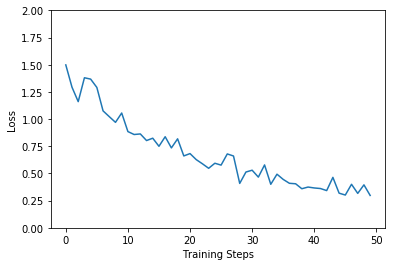

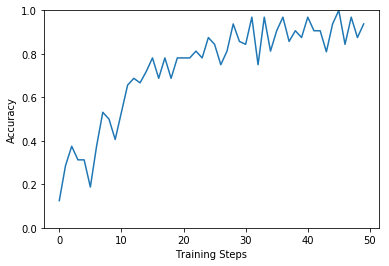

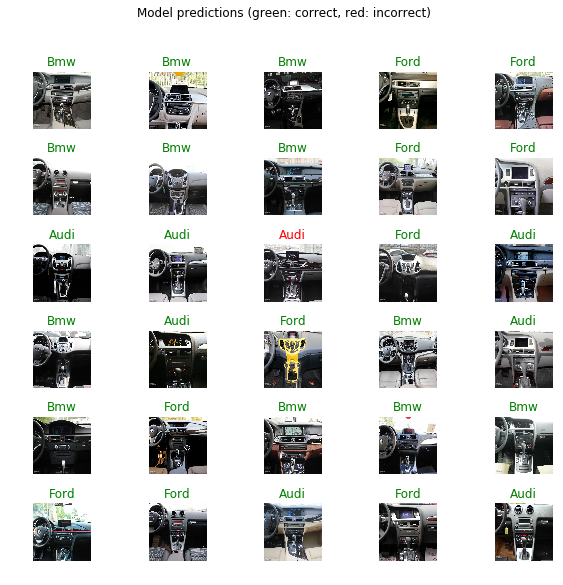

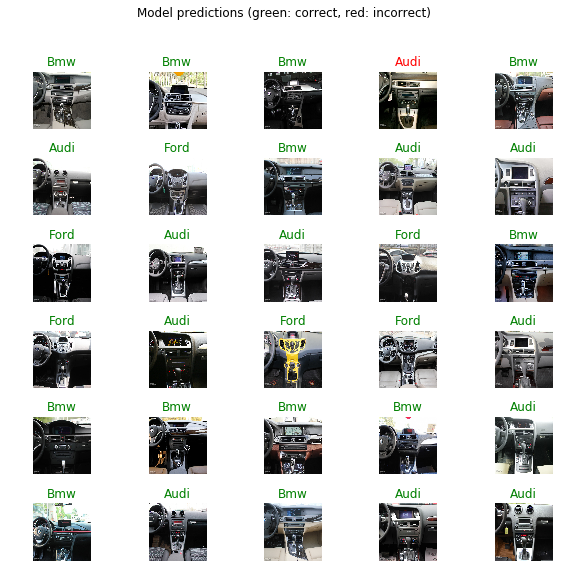

In [6]:

history = model.fit(image_data, epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback,tensorboard_callback])


plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)



class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")



class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(label_batch_test, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
%reload_ext tensorboard
#%load_ext tensorboard

# Saving, Exporting & Inference

In [0]:
saved_model_path = "/content/drive/My Drive/BIMCON Inc./demo/saved_classification_model"
tf.saved_model.save(model, saved_model_path)